In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

# Training settings
parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
parser.add_argument('--batch-size', type=int, default=128, metavar='N',
                    help='input batch size for training (default: 128)')
parser.add_argument('--epochs', type=int, default=20, metavar='N',
                    help='number of epochs to train (default: 15)')
# change lr from 0.1 to 0.001 because RMSprop can't train well if lr = 0.1(Deeper LeNet acc = 10%)
parser.add_argument('--lr', type=float, default=0.001, metavar='LR',
                    help='learning rate (default: 0.001)')
parser.add_argument('--momentum', type=float, default=0.9, metavar='M',
                    help='SGD momentum (default: 0.9)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')

# args = parser.parse_args()
# ipykernel_launcher.py: error: unrecognized arguments: -f /root/.local/share/jupyter/runtime/kernel-de000993-f144-4577-b275-810b1b2b1dc7.json
# An exception has occurred, use %tb to see the full traceback.
args = parser.parse_args(args=[]) # add args=[] to solve the error above
args.cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

# Dataloader
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./MNIST_data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.batch_size, shuffle=True,num_workers = 2)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./MNIST_data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.batch_size, shuffle=True,num_workers = 2)

# Define Network, we implement LeNet here
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=(5,5),stride=1, padding=0)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=(5,5),stride=1, padding=0)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1) #flatten
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

# Deeper LeNet
class add2convLayerNet(nn.Module):
    def __init__(self):
        super(add2convLayerNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=(5,5),stride=1, padding=0)
        # add two 3x3 conv layer
        self.conv2 = nn.Conv2d(6, 8, kernel_size=(3,3),stride=1, padding=1)
        self.conv3 = nn.Conv2d(8, 12, kernel_size=(3,3),stride=1, padding=1)
        self.conv4 = nn.Conv2d(12, 16, kernel_size=(5,5),stride=1, padding=0)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        # forward the two added conv layer
        out = self.conv2(out)
        out = self.conv3(out)
        out = F.relu(self.conv4(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1) #flatten
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

# Wider LeNet
class WiderNet(nn.Module):
    def __init__(self):
        super(WiderNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, kernel_size=(5,5),stride=1, padding=0) # change 6 to 12 for output channel
        self.conv2 = nn.Conv2d(12, 32, kernel_size=(5,5),stride=1, padding=0) # change 16 to 32 for output channel
        self.fc1 = nn.Linear(32*4*4, 240)
        self.fc2 = nn.Linear(240, 168)
        self.fc3 = nn.Linear(168, 10)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1) #flatten
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

# learning rate scheduling
def adjust_learning_rate(optimizer, epoch):
    if epoch < 10:
       lr = 0.01
    elif epoch < 15:
       lr = 0.001
    else: 
       lr = 0.0001

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Training function
def train(epoch):
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        if args.cuda:
            data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = Loss(output, target)
        loss.backward()
        optimizer.step()
        # add \r and end='' to make it print beautifully
        print('\rTrain Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()), end='')

# Testing function
def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    
    for batch_idx, (data, target) in enumerate(test_loader):
        if args.cuda:
            data, target = data.to(device), target.to(device)
        with torch.no_grad():
            output = model(data)
            test_loss += Loss(output, target).item()
            pred = output.data.max(1)[1] # get the index of the max log-probability
            correct += pred.eq(target.data).cpu().sum()

    test_loss = test_loss
    test_loss /= len(test_loader) # loss function already averages over batch size
    # change acc from .0f to .2f to evaluate the results clearly
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    acc = 100. * correct / len(test_loader.dataset)
    # return the acc for test set
    return acc


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [2]:
#### LeNet with SGD optimizer
model = Net()
if args.cuda:
	device = torch.device('cuda')
	model.to(device)

#define optimizer/loss function
Loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

# find the highest acc for test set
best_acc = 0 

#run the model and find the highest acc for test set
for epoch in range(1, args.epochs + 1):
    train(epoch)
    acc = test(epoch)
    if acc > best_acc: 
        best_acc = acc

# print the highest acc for test set
print('The best accuracy for test set: {:.2f}%'.format(best_acc))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train Epoch: 1 [44928/60000 (100%)]	Loss: 0.521089
Test set: Average loss: 0.5420, Accuracy: 8276/10000 (82.76%)

Train Epoch: 2 [44928/60000 (100%)]	Loss: 0.284703
Test set: Average loss: 0.2552, Accuracy: 9238/10000 (92.38%)

Train Epoch: 3 [44928/60000 (100%)]	Loss: 0.112345
Test set: Average loss: 0.1730, Accuracy: 9489/10000 (94.89%)

Train Epoch: 4 [44928/60000 (100%)]	Loss: 0.141767
Test set: Average loss: 0.1369, Accuracy: 9553/10000 (95.53%)

Train Epoch: 5 [44928/60000 (100%)]	Loss: 0.232820
Test set: Average loss: 0.1172, Accuracy: 9659/10000 (96.59%)

Train Epoch: 6 [44928/60000 (100%)]	Loss: 0.127505
Test set: Average loss: 0.1018, Accuracy: 9671/10000 (96.71%)

Train Epoch: 7 [44928/60000 (100%)]	Loss: 0.149753
Test set: Average loss: 0.0852, Accuracy: 9742/10000 (97.42%)

Train Epoch: 8 [44928/60000 (100%)]	Loss: 0.056986
Test set: Average loss: 0.0896, Accuracy: 9726/10000 (97.26%)

Train Epoch: 9 [44928/60000 (100%)]	Loss: 0.088311
Test set: Average loss: 0.0744, Accur

In [3]:
#### LeNet with Adam optimizer
model = Net()
if args.cuda:
	device = torch.device('cuda')
	model.to(device)

#define optimizer/loss function
Loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=args.lr)

# find the highest acc for test set
best_acc = 0 

#run the model and find the highest acc for test set
for epoch in range(1, args.epochs + 1):
    train(epoch)
    acc = test(epoch)
    if acc > best_acc: 
        best_acc = acc

# print the highest acc for test set
print('The best accuracy for test set: {:.2f}%'.format(best_acc))

Train Epoch: 1 [44928/60000 (100%)]	Loss: 0.136384
Test set: Average loss: 0.0915, Accuracy: 9720/10000 (97.20%)

Train Epoch: 2 [44928/60000 (100%)]	Loss: 0.146799
Test set: Average loss: 0.0591, Accuracy: 9815/10000 (98.15%)

Train Epoch: 3 [44928/60000 (100%)]	Loss: 0.069686
Test set: Average loss: 0.0478, Accuracy: 9846/10000 (98.46%)

Train Epoch: 4 [44928/60000 (100%)]	Loss: 0.020507
Test set: Average loss: 0.0385, Accuracy: 9868/10000 (98.68%)

Train Epoch: 5 [44928/60000 (100%)]	Loss: 0.014150
Test set: Average loss: 0.0435, Accuracy: 9870/10000 (98.70%)

Train Epoch: 6 [44928/60000 (100%)]	Loss: 0.002571
Test set: Average loss: 0.0386, Accuracy: 9869/10000 (98.69%)

Train Epoch: 7 [44928/60000 (100%)]	Loss: 0.018895
Test set: Average loss: 0.0386, Accuracy: 9873/10000 (98.73%)

Train Epoch: 8 [44928/60000 (100%)]	Loss: 0.025640
Test set: Average loss: 0.0362, Accuracy: 9892/10000 (98.92%)

Train Epoch: 9 [44928/60000 (100%)]	Loss: 0.009727
Test set: Average loss: 0.0301, Accur

In [4]:
#### LeNet with RMSprop optimizer
model = Net()
if args.cuda:
	device = torch.device('cuda')
	model.to(device)

#define optimizer/loss function
Loss = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=args.lr)

# find the highest acc for test set
best_acc = 0 

#run the model and find the highest acc for test set
for epoch in range(1, args.epochs + 1):
    train(epoch)
    acc = test(epoch)
    if acc > best_acc: 
        best_acc = acc

# print the highest acc for test set
print('The best accuracy for test set: {:.2f}%'.format(best_acc))

Train Epoch: 1 [44928/60000 (100%)]	Loss: 0.052336
Test set: Average loss: 0.0664, Accuracy: 9784/10000 (97.84%)

Train Epoch: 2 [44928/60000 (100%)]	Loss: 0.023183
Test set: Average loss: 0.0474, Accuracy: 9846/10000 (98.46%)

Train Epoch: 3 [44928/60000 (100%)]	Loss: 0.049435
Test set: Average loss: 0.0577, Accuracy: 9825/10000 (98.25%)

Train Epoch: 4 [44928/60000 (100%)]	Loss: 0.015764
Test set: Average loss: 0.0362, Accuracy: 9879/10000 (98.79%)

Train Epoch: 5 [44928/60000 (100%)]	Loss: 0.068932
Test set: Average loss: 0.0444, Accuracy: 9870/10000 (98.70%)

Train Epoch: 6 [44928/60000 (100%)]	Loss: 0.058651
Test set: Average loss: 0.0349, Accuracy: 9894/10000 (98.94%)

Train Epoch: 7 [44928/60000 (100%)]	Loss: 0.016242
Test set: Average loss: 0.0354, Accuracy: 9893/10000 (98.93%)

Train Epoch: 8 [44928/60000 (100%)]	Loss: 0.001781
Test set: Average loss: 0.0351, Accuracy: 9895/10000 (98.95%)

Train Epoch: 9 [44928/60000 (100%)]	Loss: 0.132839
Test set: Average loss: 0.0576, Accur

In [5]:
#### Deeper LeNet with SGD optimizer
model = add2convLayerNet()
if args.cuda:
	device = torch.device('cuda')
	model.to(device)

#define optimizer/loss function
Loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

# find the highest acc for test set
best_acc = 0 

#run the model and find the highest acc for test set
for epoch in range(1, args.epochs + 1):
    train(epoch)
    acc = test(epoch)
    if acc > best_acc: 
        best_acc = acc

# print the highest acc for test set
print('The best accuracy for test set: {:.2f}%'.format(best_acc))

Train Epoch: 1 [44928/60000 (100%)]	Loss: 2.284691
Test set: Average loss: 2.2871, Accuracy: 2866/10000 (28.66%)

Train Epoch: 2 [44928/60000 (100%)]	Loss: 0.546385
Test set: Average loss: 0.5019, Accuracy: 8293/10000 (82.93%)

Train Epoch: 3 [44928/60000 (100%)]	Loss: 0.267768
Test set: Average loss: 0.2473, Accuracy: 9205/10000 (92.05%)

Train Epoch: 4 [44928/60000 (100%)]	Loss: 0.153315
Test set: Average loss: 0.1805, Accuracy: 9417/10000 (94.17%)

Train Epoch: 5 [44928/60000 (100%)]	Loss: 0.125739
Test set: Average loss: 0.1363, Accuracy: 9566/10000 (95.66%)

Train Epoch: 6 [44928/60000 (100%)]	Loss: 0.199905
Test set: Average loss: 0.1125, Accuracy: 9644/10000 (96.44%)

Train Epoch: 7 [44928/60000 (100%)]	Loss: 0.066715
Test set: Average loss: 0.1095, Accuracy: 9642/10000 (96.42%)

Train Epoch: 8 [44928/60000 (100%)]	Loss: 0.093039
Test set: Average loss: 0.0794, Accuracy: 9740/10000 (97.40%)

Train Epoch: 9 [44928/60000 (100%)]	Loss: 0.024581
Test set: Average loss: 0.0730, Accur

In [6]:
#### Deeper LeNet with Adam optimizer
model = add2convLayerNet()
if args.cuda:
	device = torch.device('cuda')
	model.to(device)

#define optimizer/loss function
Loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=args.lr)

# find the highest acc for test set
best_acc = 0 

#run the model and find the highest acc for test set
for epoch in range(1, args.epochs + 1):
    train(epoch)
    acc = test(epoch)
    if acc > best_acc: 
        best_acc = acc

# print the highest acc for test set
print('The best accuracy for test set: {:.2f}%'.format(best_acc))

Train Epoch: 1 [44928/60000 (100%)]	Loss: 0.097661
Test set: Average loss: 0.0812, Accuracy: 9742/10000 (97.42%)

Train Epoch: 2 [44928/60000 (100%)]	Loss: 0.056243
Test set: Average loss: 0.0544, Accuracy: 9819/10000 (98.19%)

Train Epoch: 3 [44928/60000 (100%)]	Loss: 0.023339
Test set: Average loss: 0.0456, Accuracy: 9843/10000 (98.43%)

Train Epoch: 4 [44928/60000 (100%)]	Loss: 0.059193
Test set: Average loss: 0.0363, Accuracy: 9881/10000 (98.81%)

Train Epoch: 5 [44928/60000 (100%)]	Loss: 0.019908
Test set: Average loss: 0.0406, Accuracy: 9872/10000 (98.72%)

Train Epoch: 6 [44928/60000 (100%)]	Loss: 0.084517
Test set: Average loss: 0.0341, Accuracy: 9883/10000 (98.83%)

Train Epoch: 7 [44928/60000 (100%)]	Loss: 0.005667
Test set: Average loss: 0.0387, Accuracy: 9866/10000 (98.66%)

Train Epoch: 8 [44928/60000 (100%)]	Loss: 0.020181
Test set: Average loss: 0.0341, Accuracy: 9894/10000 (98.94%)

Train Epoch: 9 [44928/60000 (100%)]	Loss: 0.009723
Test set: Average loss: 0.0363, Accur

In [7]:
#### Deeper LeNet with RMSprop optimizer
model = add2convLayerNet()
if args.cuda:
	device = torch.device('cuda')
	model.to(device)

#define optimizer/loss function
Loss = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=args.lr)

# find the highest acc for test set
best_acc = 0 

#run the model and find the highest acc for test set
for epoch in range(1, args.epochs + 1):
    train(epoch)
    acc = test(epoch)
    if acc > best_acc: 
        best_acc = acc

# print the highest acc for test set
print('The best accuracy for test set: {:.2f}%'.format(best_acc))

Train Epoch: 1 [44928/60000 (100%)]	Loss: 0.070122
Test set: Average loss: 0.0877, Accuracy: 9717/10000 (97.17%)

Train Epoch: 2 [44928/60000 (100%)]	Loss: 0.058242
Test set: Average loss: 0.0665, Accuracy: 9777/10000 (97.77%)

Train Epoch: 3 [44928/60000 (100%)]	Loss: 0.010468
Test set: Average loss: 0.0457, Accuracy: 9849/10000 (98.49%)

Train Epoch: 4 [44928/60000 (100%)]	Loss: 0.047219
Test set: Average loss: 0.0547, Accuracy: 9816/10000 (98.16%)

Train Epoch: 5 [44928/60000 (100%)]	Loss: 0.041766
Test set: Average loss: 0.0502, Accuracy: 9871/10000 (98.71%)

Train Epoch: 6 [44928/60000 (100%)]	Loss: 0.015273
Test set: Average loss: 0.0357, Accuracy: 9882/10000 (98.82%)

Train Epoch: 7 [44928/60000 (100%)]	Loss: 0.019062
Test set: Average loss: 0.0441, Accuracy: 9863/10000 (98.63%)

Train Epoch: 8 [44928/60000 (100%)]	Loss: 0.046694
Test set: Average loss: 0.0569, Accuracy: 9826/10000 (98.26%)

Train Epoch: 9 [44928/60000 (100%)]	Loss: 0.014978
Test set: Average loss: 0.0343, Accur

In [8]:
#### Wider LeNet with SGD optimizer
model = WiderNet()
if args.cuda:
	device = torch.device('cuda')
	model.to(device)

#define optimizer/loss function
Loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

# find the highest acc for test set
best_acc = 0 

#run the model and find the highest acc for test set
for epoch in range(1, args.epochs + 1):
    train(epoch)
    acc = test(epoch)
    if acc > best_acc: 
        best_acc = acc

# print the highest acc for test set
print('The best accuracy for test set: {:.2f}%'.format(best_acc))

Train Epoch: 1 [44928/60000 (100%)]	Loss: 0.464757
Test set: Average loss: 0.4459, Accuracy: 8730/10000 (87.30%)

Train Epoch: 2 [44928/60000 (100%)]	Loss: 0.117630
Test set: Average loss: 0.2231, Accuracy: 9336/10000 (93.36%)

Train Epoch: 3 [44928/60000 (100%)]	Loss: 0.066517
Test set: Average loss: 0.1496, Accuracy: 9544/10000 (95.44%)

Train Epoch: 4 [44928/60000 (100%)]	Loss: 0.094041
Test set: Average loss: 0.1351, Accuracy: 9567/10000 (95.67%)

Train Epoch: 5 [44928/60000 (100%)]	Loss: 0.127241
Test set: Average loss: 0.0953, Accuracy: 9709/10000 (97.09%)

Train Epoch: 6 [44928/60000 (100%)]	Loss: 0.073465
Test set: Average loss: 0.0917, Accuracy: 9724/10000 (97.24%)

Train Epoch: 7 [44928/60000 (100%)]	Loss: 0.074627
Test set: Average loss: 0.0724, Accuracy: 9784/10000 (97.84%)

Train Epoch: 8 [44928/60000 (100%)]	Loss: 0.093582
Test set: Average loss: 0.0766, Accuracy: 9759/10000 (97.59%)

Train Epoch: 9 [44928/60000 (100%)]	Loss: 0.027478
Test set: Average loss: 0.0669, Accur

In [9]:
#### Wider LeNet with Adam optimizer
model = WiderNet()
if args.cuda:
	device = torch.device('cuda')
	model.to(device)

#define optimizer/loss function
Loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=args.lr)

# find the highest acc for test set
best_acc = 0 

#run the model and find the highest acc for test set
for epoch in range(1, args.epochs + 1):
    train(epoch)
    acc = test(epoch)
    if acc > best_acc: 
        best_acc = acc

# print the highest acc for test set
print('The best accuracy for test set: {:.2f}%'.format(best_acc))

Train Epoch: 1 [44928/60000 (100%)]	Loss: 0.080392
Test set: Average loss: 0.0592, Accuracy: 9826/10000 (98.26%)

Train Epoch: 2 [44928/60000 (100%)]	Loss: 0.166922
Test set: Average loss: 0.0475, Accuracy: 9862/10000 (98.62%)

Train Epoch: 3 [44928/60000 (100%)]	Loss: 0.014423
Test set: Average loss: 0.0356, Accuracy: 9878/10000 (98.78%)

Train Epoch: 4 [44928/60000 (100%)]	Loss: 0.039236
Test set: Average loss: 0.0299, Accuracy: 9900/10000 (99.00%)

Train Epoch: 5 [44928/60000 (100%)]	Loss: 0.088735
Test set: Average loss: 0.0314, Accuracy: 9893/10000 (98.93%)

Train Epoch: 6 [44928/60000 (100%)]	Loss: 0.016848
Test set: Average loss: 0.0298, Accuracy: 9902/10000 (99.02%)

Train Epoch: 7 [44928/60000 (100%)]	Loss: 0.022874
Test set: Average loss: 0.0378, Accuracy: 9895/10000 (98.95%)

Train Epoch: 8 [44928/60000 (100%)]	Loss: 0.000637
Test set: Average loss: 0.0334, Accuracy: 9907/10000 (99.07%)

Train Epoch: 9 [44928/60000 (100%)]	Loss: 0.002895
Test set: Average loss: 0.0419, Accur

In [10]:
#### Wider LeNet with RMSprop optimizer
model = WiderNet()
if args.cuda:
	device = torch.device('cuda')
	model.to(device)

#define optimizer/loss function
Loss = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=args.lr)

# find the highest acc for test set
best_acc = 0 

#run the model and find the highest acc for test set
for epoch in range(1, args.epochs + 1):
    train(epoch)
    acc = test(epoch)
    if acc > best_acc: 
        best_acc = acc

# print the highest acc for test set
print('The best accuracy for test set: {:.2f}%'.format(best_acc))

Train Epoch: 1 [44928/60000 (100%)]	Loss: 0.069552
Test set: Average loss: 0.0647, Accuracy: 9792/10000 (97.92%)

Train Epoch: 2 [44928/60000 (100%)]	Loss: 0.076187
Test set: Average loss: 0.0464, Accuracy: 9847/10000 (98.47%)

Train Epoch: 3 [44928/60000 (100%)]	Loss: 0.107455
Test set: Average loss: 0.0441, Accuracy: 9866/10000 (98.66%)

Train Epoch: 4 [44928/60000 (100%)]	Loss: 0.004259
Test set: Average loss: 0.0250, Accuracy: 9910/10000 (99.10%)

Train Epoch: 5 [44928/60000 (100%)]	Loss: 0.002606
Test set: Average loss: 0.0401, Accuracy: 9883/10000 (98.83%)

Train Epoch: 6 [44928/60000 (100%)]	Loss: 0.030747
Test set: Average loss: 0.0355, Accuracy: 9888/10000 (98.88%)

Train Epoch: 7 [44928/60000 (100%)]	Loss: 0.006684
Test set: Average loss: 0.0346, Accuracy: 9917/10000 (99.17%)

Train Epoch: 8 [44928/60000 (100%)]	Loss: 0.006023
Test set: Average loss: 0.0345, Accuracy: 9905/10000 (99.05%)

Train Epoch: 9 [44928/60000 (100%)]	Loss: 0.000361
Test set: Average loss: 0.0344, Accur

# Comparison


1.   LeNet with SGD optimizer : 98.45%
2.   LeNet with Adam optimizer : 99.16%
    - without adjust_learning_rate function have poor performance at about 15%
3.   LeNet with RMSprop optimizer : 99.12%
    - without adjust_learning_rate function have poor performance at about 11%
4.   Deeper LeNet with SGD optimizer : 98.50% 
    - **+0.05%** compare to original LeNet with SGD
5.   Deeper LeNet with Adam optimizer : 99.09% 
    - **-0.07%** compare to original LeNet with Adam
6.   Deeper LeNet with RMSprop optimizer : 99.03%
    - **-0.09%** compare to original LeNet with RMSprop
7.   Wider LeNet with SGD optimizer : 98.78% 
    - **+0.33%** compare to original LeNet with SGD
8.   Wider LeNet with Adam optimizer : 99.23% 
    - **+0.07%** compare to original LeNet with Adam
9.   Wider LeNet with RMSprop optimizer : 99.25%
    - **+0.13%** compare to original LeNet with RMSprop

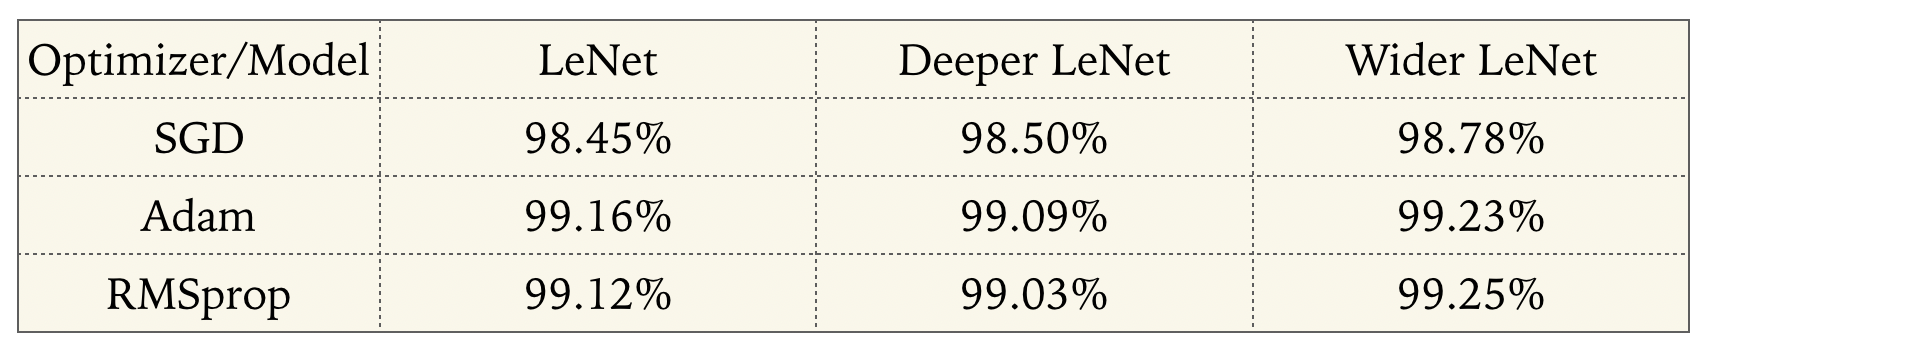









# Conclusion
準確率最高的組合是加寬的 LeNet 搭配 RMSprop optimizer -> 99.25%

我覺得可能是因為 MNIST data 本身就沒有很複雜，所以加深或是加寬網路不會讓準確率有大幅提升的效果，但也有可能是因為原始 LeNet 的準確率就已經很高，所以沒什麼進步空間XD

